##### Version 01

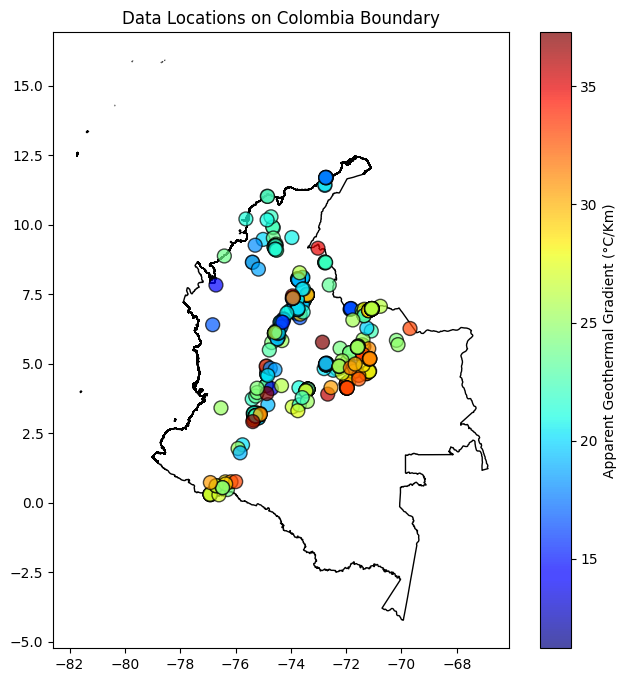

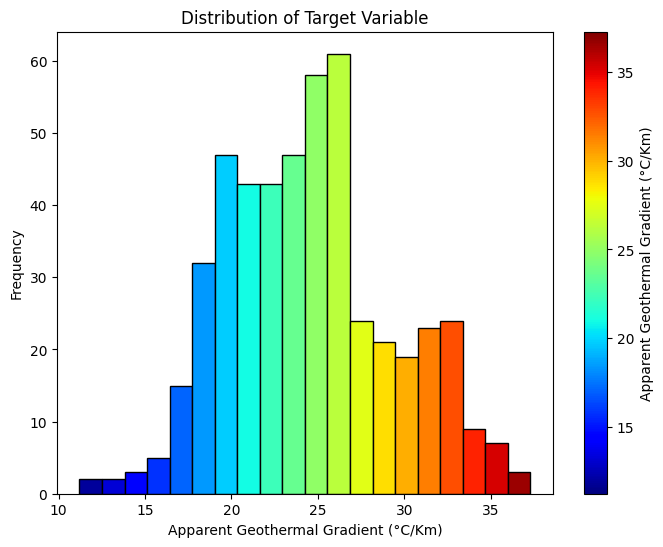

Fitted spherical model: len_scale=3.63, nugget=12.6160, sill=13.2628, MSE=9.9975e+02
Fitted exponential model: len_scale=1.05, nugget=4.8451, sill=21.3424, MSE=1.0030e+03
Fitted gaussian model: len_scale=0.40, nugget=9.9200, sill=14.5751, MSE=1.0024e+03

Variogram Fitting Metrics:
         model  len_scale     nugget       sill          MSE
0    spherical   3.626597  12.615974  13.262782   999.745001
1  exponential   1.047216   4.845107  21.342378  1002.973355
2     gaussian   0.397381   9.920014  14.575145  1002.407036

Best model selected: spherical
Parameters: len_scale=3.63, nugget=12.6160, sill=13.2628


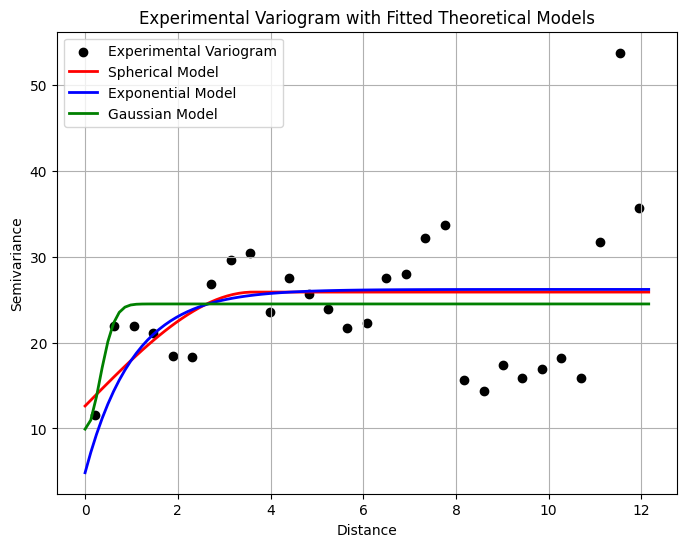

RF_full CV metrics: RMSE = 3.8208e+00, MAE = 2.6740e+00, R2 = 0.3787
RF_vector CV metrics: RMSE = 3.8529e+00, MAE = 2.6809e+00, R2 = 0.3682
RF_nn CV metrics: RMSE = 3.8551e+00, MAE = 2.6954e+00, R2 = 0.3674
RF_coordinates CV metrics: RMSE = 3.8724e+00, MAE = 2.6783e+00, R2 = 0.3618
GBR_full CV metrics: RMSE = 3.9400e+00, MAE = 2.7399e+00, R2 = 0.3393
GBR_coordinates CV metrics: RMSE = 3.8065e+00, MAE = 2.6133e+00, R2 = 0.3833
SVR_buffer CV metrics: RMSE = 3.9260e+00, MAE = 2.7735e+00, R2 = 0.3440
KNN_full CV metrics: RMSE = 3.9592e+00, MAE = 2.6964e+00, R2 = 0.3328
MLP_nn CV metrics: RMSE = 4.0086e+00, MAE = 2.7904e+00, R2 = 0.3160

CV Metrics:
                     RMSE       MAE        R2
RF_full          3.820787  2.674012  0.378651
RF_vector        3.852857  2.680905  0.368176
RF_nn            3.855074  2.695438  0.367449
RF_coordinates   3.872396  2.678278  0.361752
GBR_full         3.939964  2.739900  0.339284
GBR_coordinates  3.806521  2.613270  0.383282
SVR_buffer       3.925968

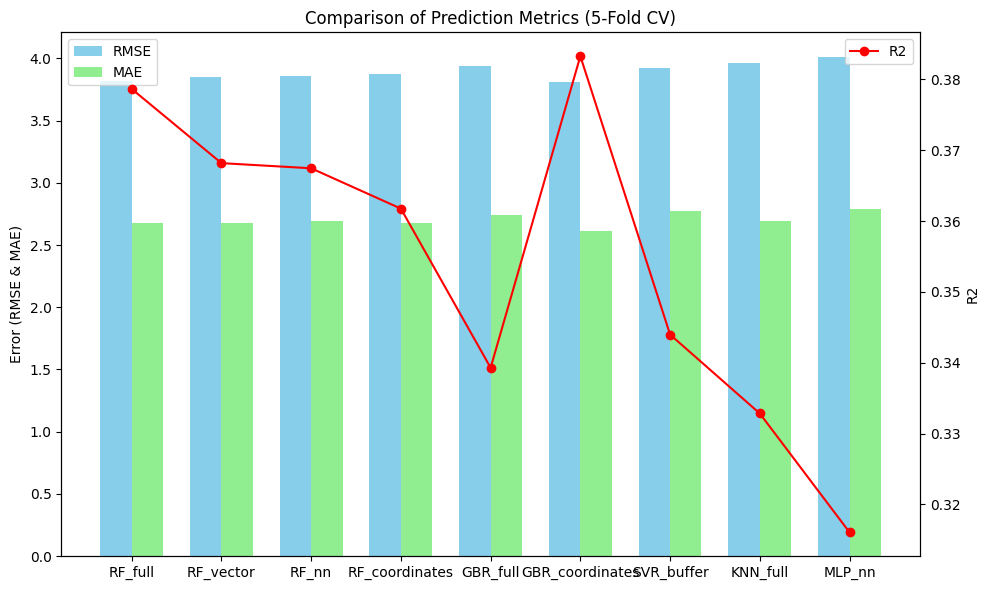

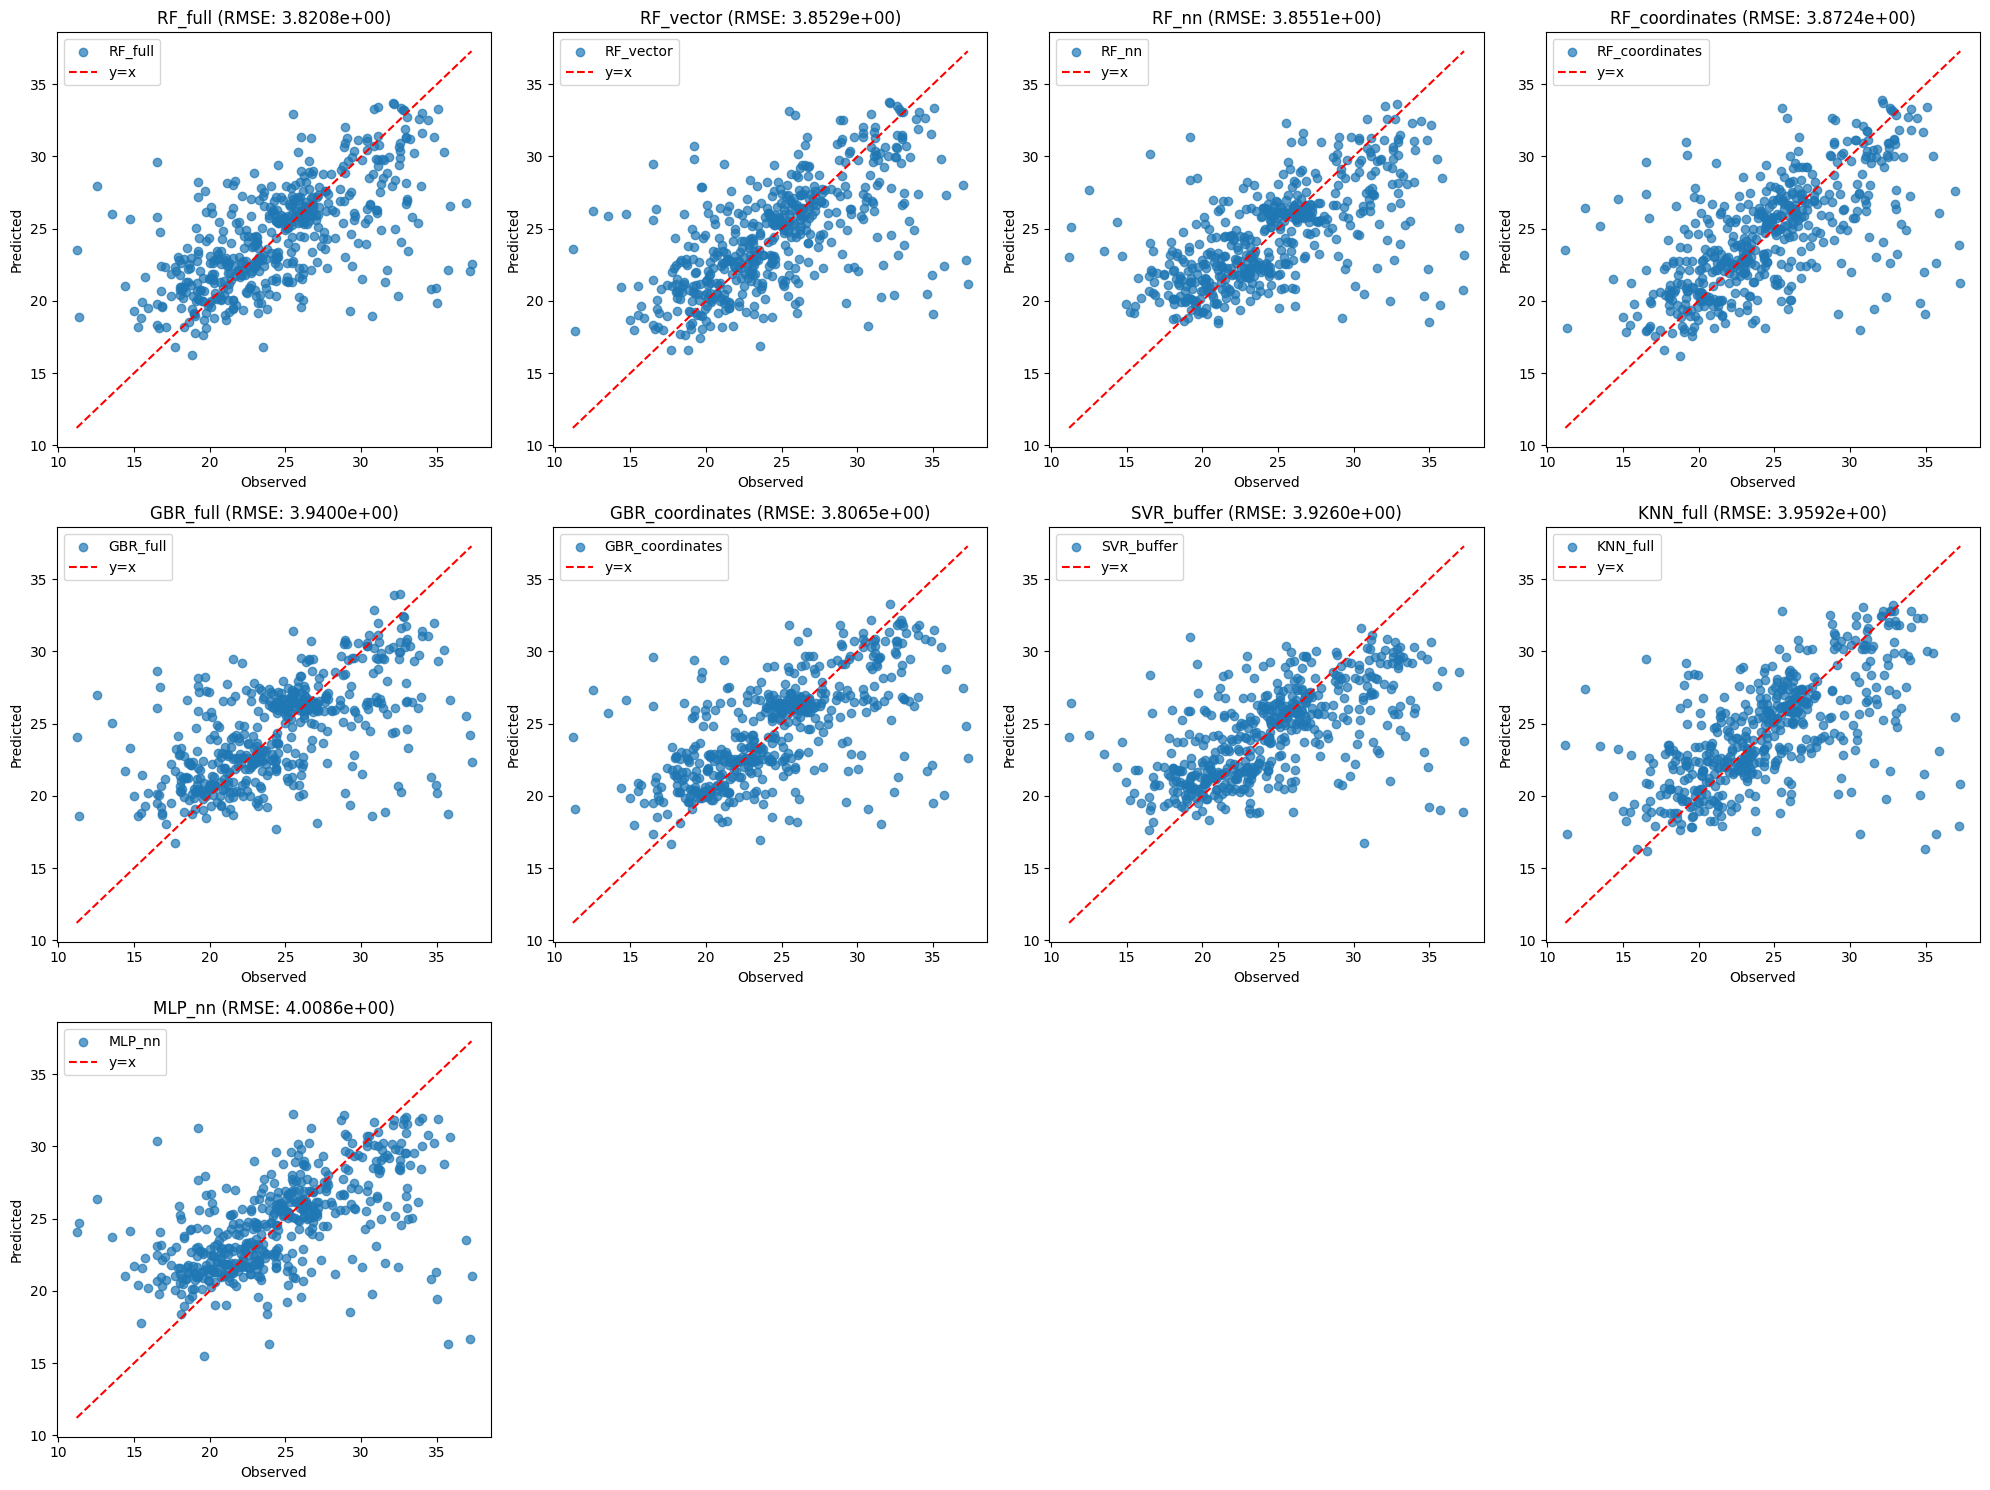


Best AI spatial interpolation model based on 5-fold CV: GBR_coordinates with RMSE = 3.8065e+00


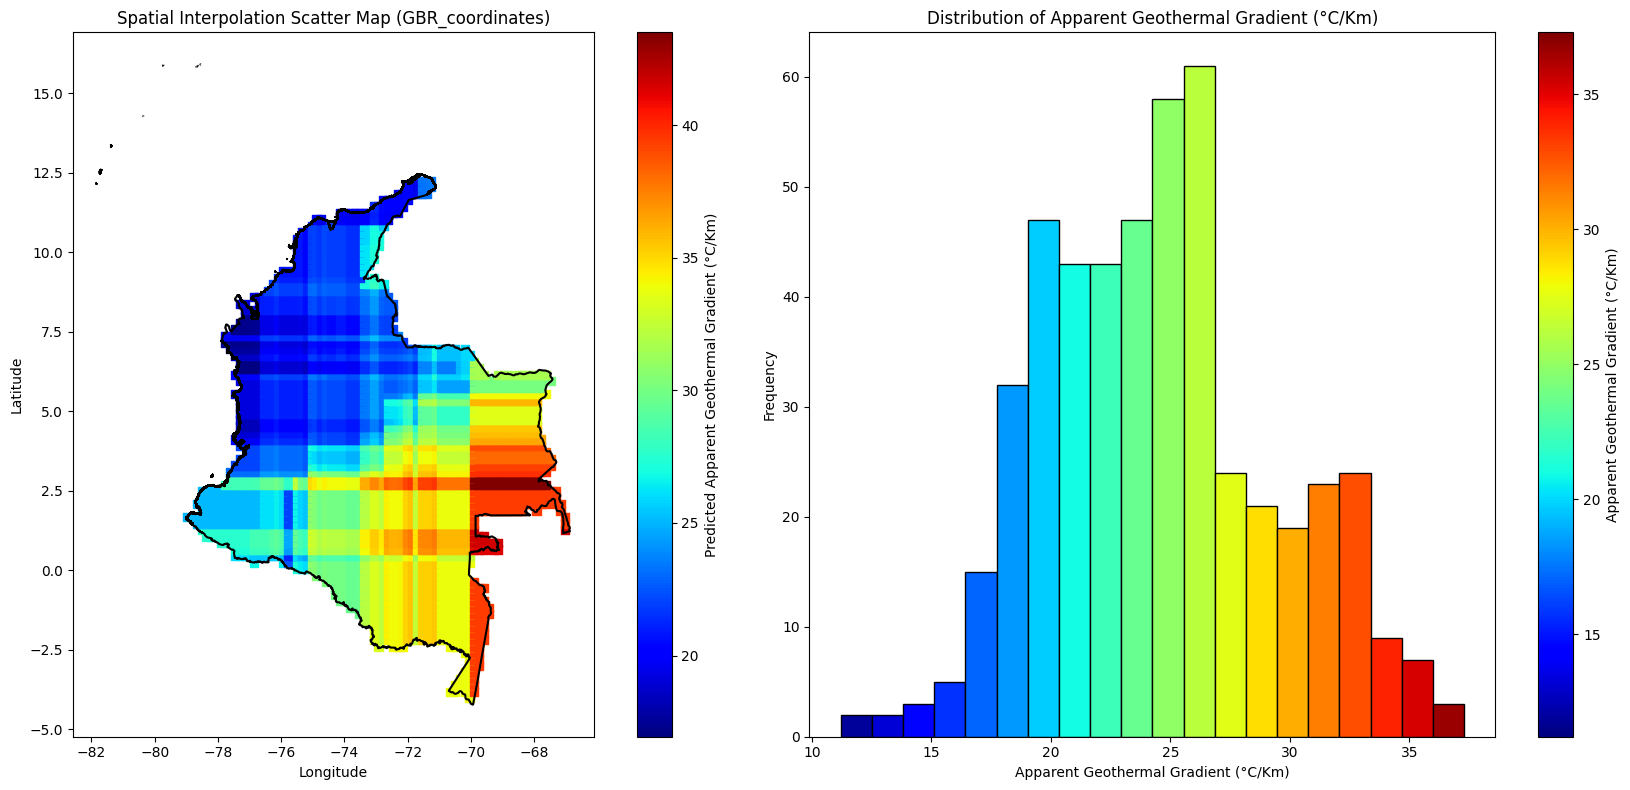

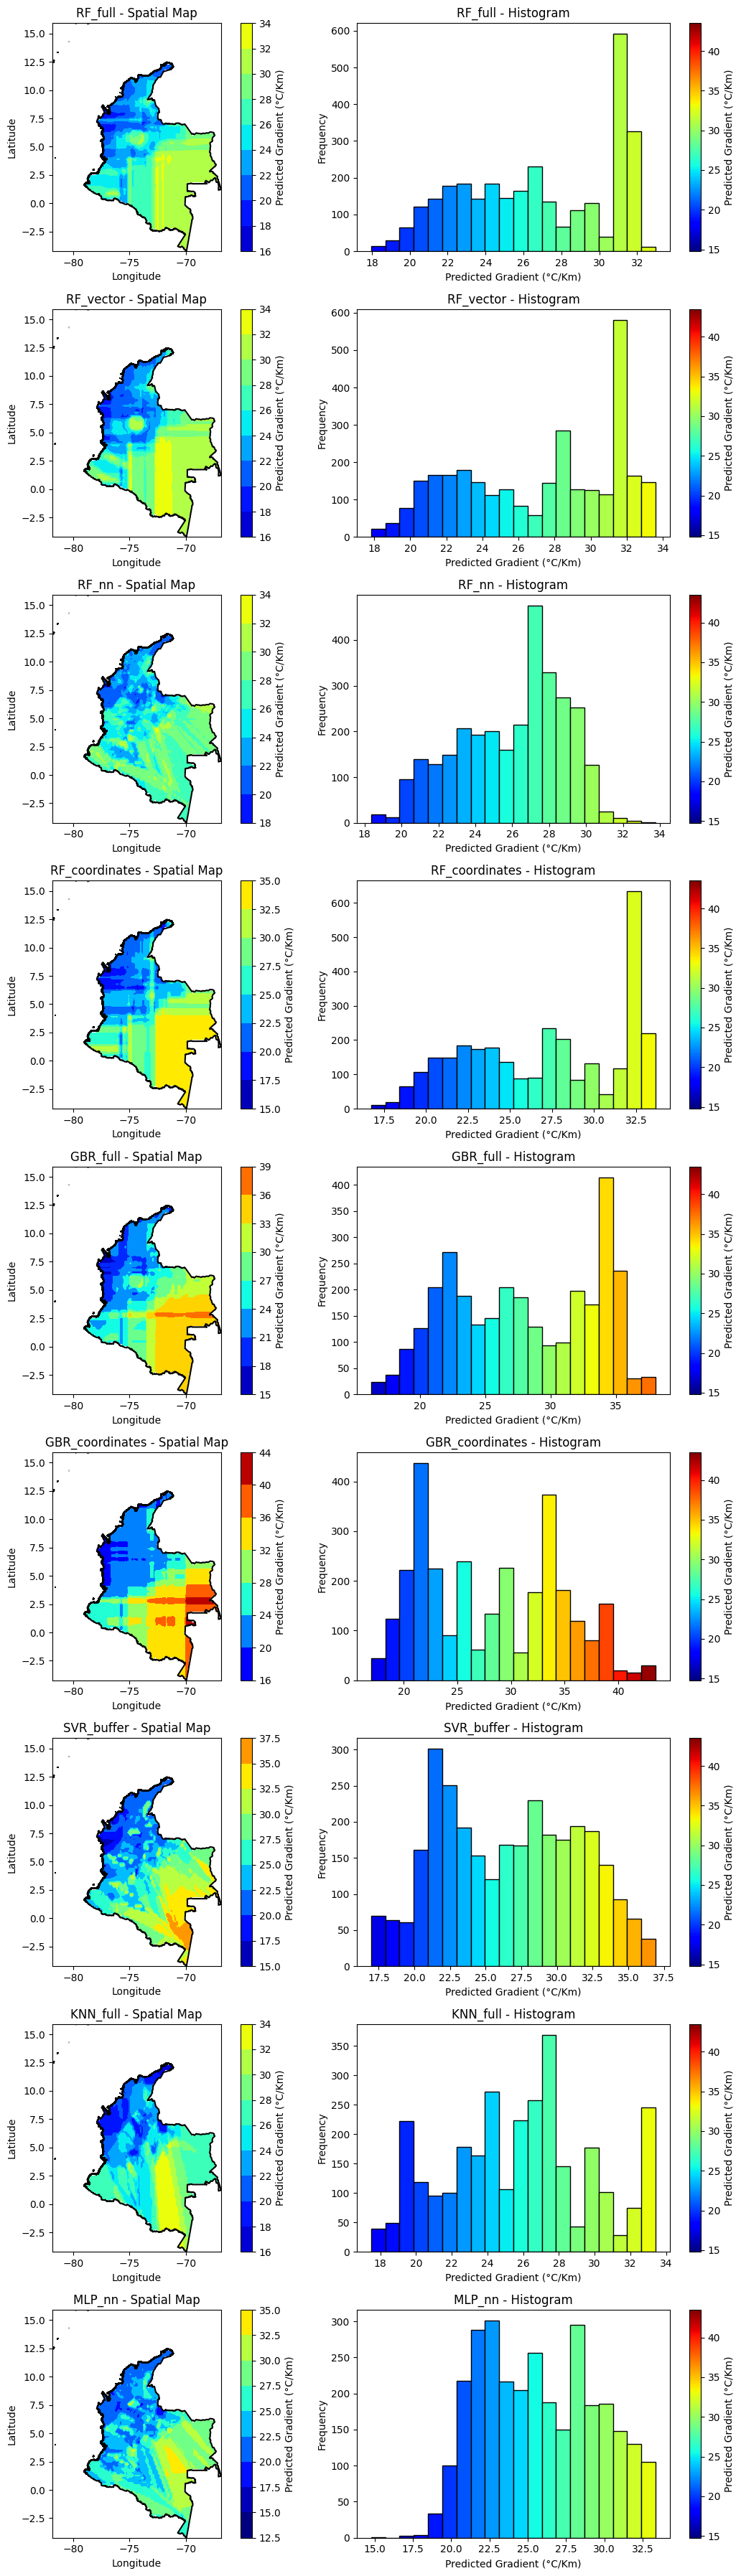


5-Fold CV Metrics for AI Models:
                     RMSE       MAE        R2
RF_full          3.820787  2.674012  0.378651
RF_vector        3.852857  2.680905  0.368176
RF_nn            3.855074  2.695438  0.367449
RF_coordinates   3.872396  2.678278  0.361752
GBR_full         3.939964  2.739900  0.339284
GBR_coordinates  3.806521  2.613270  0.383282
SVR_buffer       3.925968  2.773548  0.343970
KNN_full         3.959163  2.696449  0.332829
MLP_nn           4.008645  2.790446  0.316048

Best AI spatial interpolation model based on 5-fold CV: GBR_coordinates with RMSE = 3.8065e+00


In [2]:
"""
Complete Spatial Interpolation Workflow Script (Using jet Colormap)
-----------------------------------------------------------------------

This script:
1. Sets up output folders.
2. Loads data, removes outliers, and loads the Colombia boundary.
3. Plots data locations and the distribution of the target.
4. Computes an experimental variogram and fits theoretical models.
5. Engineers features for AI models.
   It computes four feature sets:
       - "full": selected_features = ["x", "y", "x2", "y2", "xy", "dist_centroid", "mean_nn"]
       - "buffer": features from [x, y, dist_centroid, min_nn, nn_value]
       - "nn": features from [x, "y"] plus nearest neighbor distances and values (for a chosen number)
       - "vector": simply [x, y, dist_centroid]
6. Performs 5-fold cross-validation for several AI regression models.
   Models and their feature set mappings:
       - "RF_full": uses "full" features.
       - "RF_vector": uses "vector" features.
       - "RF_nn": uses "nn" features.
       - "RF_coordinates": uses "coords" features.
       - "GBR_full": uses "full" features.
       - "GBR_coordinates": uses "coords" features.
       - "SVR_buffer": uses "buffer" features.
       - "KNN_full": uses "full" features.
       - "MLP_nn": uses "nn" features.
   Computes RMSE, MAE, and R²; produces a dual-axis comparison plot and per-model CV scatter plots.
7. Saves the optimal AI models.
8. Creates a prediction grid within the Colombia boundary and computes grid features.
9. Uses the best AI model to predict on the grid.
10. Masks grid predictions to the Colombia boundary.
11. Plots a final scatter map and histogram (using jet colormap) for the best model.
12. Additionally, produces spatial interpolation maps and histograms for each AI model,
    with all plots sharing the same color scale.
13. Prints the CV metrics.
"""

#########################################
# 0. Import Libraries and Suppress Warnings
#########################################
import os, pickle, warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
import gstools as gs
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler

#########################################
# 0a. Nearest Neighbor Configuration
#########################################
n_neighbors = 7        # Total neighbors to compute (including self)
nn_feature_count = 4   # Number of neighbors (excluding self) to use for NN features
max_neighbor_distance = None  # Maximum allowed neighbor distance (or None)

#########################################
# 1. Setup Output Folders
#########################################
output_dir = "AI_Output_01"
for subfolder in ["models", "plots", "results"]:
    os.makedirs(os.path.join(output_dir, subfolder), exist_ok=True)

#########################################
# 2. Load Data, Remove Outliers and Load Colombia Boundary
#########################################
data = pd.read_csv("Data/data_pre_norm.csv").head(500)
target_var = "Apparent Geothermal Gradient (°C/Km)"
values = data[target_var].values
q1 = np.percentile(values, 25)
q3 = np.percentile(values, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
mask = (values >= lower_bound) & (values <= upper_bound)
data = data[mask].reset_index(drop=True)

# Define target from the cleaned data.
target = data[target_var].values

lat = data["Latitude"].values
lon = data["Longitude"].values
values = target.copy()  # use original target values
coords = np.vstack((lon, lat)).T

colombia_boundary = gpd.read_file("./Data/COL_adm0.shp")
if colombia_boundary.crs is None:
    colombia_boundary.set_crs(epsg=4326, inplace=True)
colombia_boundary = colombia_boundary.to_crs("epsg:4326")

#########################################
# 3. Plot Data Locations and Distribution
#########################################
data_gdf = gpd.GeoDataFrame(data, geometry=[Point(xy) for xy in zip(lon, lat)], crs="epsg:4326")
fig, ax = plt.subplots(figsize=(8, 8))
colombia_boundary.plot(ax=ax, color='none', edgecolor='black')
sc = ax.scatter(lon, lat, c=values, cmap="jet", s=100, alpha=0.7, edgecolor='k')
ax.set_title("Data Locations on Colombia Boundary")
plt.colorbar(sc, ax=ax, label=target_var)
plt.savefig(os.path.join(output_dir, "plots", "data_locations.png"))
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
n, bins_hist, patches = ax.hist(values, bins=20, edgecolor="black")
ax.set_title("Distribution of Target Variable")
ax.set_xlabel("Apparent Geothermal Gradient (°C/Km)")
ax.set_ylabel("Frequency")
hist_norm = mcolors.Normalize(vmin=np.min(values), vmax=np.max(values))
bin_centers = 0.5*(bins_hist[:-1]+bins_hist[1:])
for patch, center in zip(patches, bin_centers):
    patch.set_facecolor(cm.jet(hist_norm(center)))
sm = cm.ScalarMappable(cmap="jet", norm=hist_norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Apparent Geothermal Gradient (°C/Km)")
plt.savefig(os.path.join(output_dir, "plots", "target_distribution.png"))
plt.show()

#########################################
# 4. Experimental Variogram and Fitting
#########################################
dists = squareform(pdist(coords))
semivariance = 0.5*(values[:, None] - values)**2
bin_edges = np.linspace(0, dists.max(), 30)
bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])
bin_vals = np.zeros_like(bin_centers)
for i in range(len(bin_edges)-1):
    mask_bin = (dists.ravel()>=bin_edges[i]) & (dists.ravel()<bin_edges[i+1])
    if np.any(mask_bin):
        bin_vals[i] = np.mean(semivariance.ravel()[mask_bin])
def model_semivariance(model, h):
    return model.var + model.nugget - model.covariance(h)
theoretical_models = {"spherical": gs.Spherical,
                      "exponential": gs.Exponential,
                      "gaussian": gs.Gaussian}
fitted_models = {}
metrics = []
def mse_model(params, model_class, distances, exp_var):
    model_instance = model_class(len_scale=params[0], nugget=params[1], var=params[2])
    y_pred = model_semivariance(model_instance, distances)
    return np.mean((y_pred - exp_var)**2)
initial_guess = [dists.max()/2, 0.0, np.var(values)]
bounds = [(1e-6, None), (0, None), (1e-6, None)]
for name, model_class in theoretical_models.items():
    res = minimize(mse_model, initial_guess, args=(model_class, dists.ravel(), semivariance.ravel()), bounds=bounds)
    model_inst = model_class(len_scale=res.x[0], nugget=res.x[1], var=res.x[2])
    mse_val = res.fun
    fitted_models[name] = model_inst
    metrics.append({"model": name,
                    "len_scale": res.x[0],
                    "nugget": res.x[1],
                    "sill": res.x[2],
                    "MSE": mse_val})
    print(f"Fitted {name} model: len_scale={res.x[0]:.2f}, nugget={res.x[1]:.4f}, sill={res.x[2]:.4f}, MSE={mse_val:.4e}")
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(os.path.join(output_dir, "results", "variogram_fitting_metrics.csv"), index=False)
print("\nVariogram Fitting Metrics:")
print(metrics_df)
best_model_name = metrics_df.loc[metrics_df["MSE"].idxmin(), "model"]
best_model = fitted_models[best_model_name]
print(f"\nBest model selected: {best_model_name}")
print(f"Parameters: len_scale={best_model.len_scale:.2f}, nugget={best_model.nugget:.4f}, sill={best_model.var:.4f}")
var_model_str = best_model_name
var_params = {"range": best_model.len_scale, "sill": best_model.var, "nugget": best_model.nugget}
plt.figure(figsize=(8, 6))
plt.scatter(bin_centers, bin_vals, color='black', label="Experimental Variogram")
h_vals = np.linspace(0, dists.max(), 100)
colors = {"spherical": "red", "exponential": "blue", "gaussian": "green"}
for name, model in fitted_models.items():
    theo = model_semivariance(model, h_vals)
    plt.plot(h_vals, theo, color=colors[name], lw=2, label=f"{name.capitalize()} Model")
plt.xlabel("Distance")
plt.ylabel("Semivariance")
plt.title("Experimental Variogram with Fitted Theoretical Models")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "plots", "variogram_fitted_models.png"))
plt.show()

#########################################
# 5. Feature Engineering for AI Models
#########################################
# Compute basic features.
df_features = pd.DataFrame({"x": coords[:, 0], "y": coords[:, 1]})
df_features["x2"] = df_features["x"] ** 2
df_features["y2"] = df_features["y"] ** 2
df_features["xy"] = df_features["x"] * df_features["y"]
centroid_x = df_features["x"].mean()
centroid_y = df_features["y"].mean()
df_features["dist_centroid"] = np.sqrt((df_features["x"] - centroid_x)**2 +
                                         (df_features["y"] - centroid_y)**2)
# Compute nearest neighbors for observations.
nbrs_all = NearestNeighbors(n_neighbors=n_neighbors).fit(coords)
distances_all, indices_all = nbrs_all.kneighbors(coords)
if max_neighbor_distance is not None:
    distances_all[distances_all > max_neighbor_distance] = np.nan
# Buffer features: use the first non-self neighbor (index 1).
df_features["min_nn"] = distances_all[:, 1]
df_features["nn_value"] = values[indices_all[:, 1]]
# NN features: use the next 'nn_feature_count' neighbors (indices 1 to nn_feature_count).
nn_feature_cols = []
for i in range(1, nn_feature_count + 1):
    col_dist = f"nn{i}_distance"
    col_val = f"nn{i}_value"
    df_features[col_dist] = distances_all[:, i]
    df_features[col_val] = values[indices_all[:, i]]
    nn_feature_cols.extend([col_dist, col_val])
# Compute mean_nn using the first nn_feature_count neighbors.
df_features["mean_nn"] = np.nanmean(distances_all[:, 1:nn_feature_count+1], axis=1)

# Define feature sets.
selected_features = ["x", "y", "x2", "y2", "xy", "dist_centroid", "mean_nn"]
# "full" features.
features_full = df_features[selected_features].values
# "vector" features: [x, y, dist_centroid]
features_vector = df_features[["x", "y", "dist_centroid"]].values
# "buffer" features: [x, y, dist_centroid, min_nn, nn_value]
features_buffer = df_features[["x", "y", "dist_centroid", "min_nn", "nn_value"]].values
# "nn" features: [x, y] + nn_feature_cols.
features_nn = df_features[["x", "y"] + nn_feature_cols].values
# "coords": [x, y]
features_coords = df_features[["x", "y"]].values

#########################################
# 6. 5-Fold Cross Validation for AI Spatial Interpolation Models
#########################################
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Define AI regression models.
# New models with mapping:
# - "RF_full": uses "full" features.
# - "RF_vector": uses "vector" features.
# - "RF_nn": uses "nn" features.
# - "RF_coordinates": uses "coords" features.
# - "GBR_full": uses "full" features.
# - "GBR_coordinates": uses "coords" features.
# - "SVR_buffer": uses "buffer" features.
# - "KNN_full": uses "full" features.
# - "MLP_nn": uses "nn" features.
ai_models = {
    "RF_full": RandomForestRegressor(random_state=42),
    "RF_vector": RandomForestRegressor(random_state=42),
    "RF_nn": RandomForestRegressor(random_state=42),
    "RF_coordinates": RandomForestRegressor(random_state=42),
    "GBR_full": GradientBoostingRegressor(random_state=42),
    "GBR_coordinates": GradientBoostingRegressor(random_state=42),
    "SVR_buffer": TransformedTargetRegressor(
                    regressor=SVR(C=10, epsilon=0.1, gamma='scale'),
                    transformer=StandardScaler()),
    "KNN_full": KNeighborsRegressor(),
    "MLP_nn": TransformedTargetRegressor(
                    regressor=MLPRegressor(random_state=42, max_iter=1000, early_stopping=True,
                                            hidden_layer_sizes=(100,50), activation='relu',
                                            solver='adam', learning_rate_init=0.001),
                    transformer=StandardScaler())
}
# Map each model to its feature set.
# "full": use features_full
# "vector": use features_vector
# "buffer": use features_buffer
# "nn": use features_nn
# "coords": use features_coords
model_feature = {
    "RF_full": "full",
    "RF_vector": "vector",
    "RF_nn": "nn",
    "RF_coordinates": "coords",
    "GBR_full": "full",
    "GBR_coordinates": "coords",
    "SVR_buffer": "buffer",
    "KNN_full": "full",
    "MLP_nn": "nn"
}
X_full = features_full
X_vector = features_vector
X_buffer = features_buffer
X_nn = features_nn
X_coords = features_coords

cv_results = {name: {"observed": [], "predicted": []} for name in ai_models.keys()}
for train_idx, test_idx in kf.split(X_full):  # same indices for all sets
    X_train_full, X_test_full = X_full[train_idx], X_full[test_idx]
    X_train_vector, X_test_vector = X_vector[train_idx], X_vector[test_idx]
    X_train_buffer, X_test_buffer = X_buffer[train_idx], X_buffer[test_idx]
    X_train_nn, X_test_nn = X_nn[train_idx], X_nn[test_idx]
    X_train_coords, X_test_coords = X_coords[train_idx], X_coords[test_idx]
    y_train, y_test = target[train_idx], target[test_idx]
    
    for model_name, model in ai_models.items():
        feat_set = model_feature[model_name]
        if feat_set == "full":
            X_train, X_test = X_train_full, X_test_full
        elif feat_set == "vector":
            X_train, X_test = X_train_vector, X_test_vector
        elif feat_set == "buffer":
            X_train, X_test = X_train_buffer, X_test_buffer
        elif feat_set == "nn":
            X_train, X_test = X_train_nn, X_test_nn
        elif feat_set == "coords":
            X_train, X_test = X_train_coords, X_test_coords
        else:
            X_train, X_test = X_train_full, X_test_full  # fallback
        model_trained = model.fit(X_train, y_train)
        pred = model_trained.predict(X_test)
        cv_results[model_name]["observed"].extend(y_test)
        cv_results[model_name]["predicted"].extend(pred)

cv_metrics = {}
for method, results in cv_results.items():
    obs_arr = np.array(results["observed"])
    pred_arr = np.array(results["predicted"])
    rmse = np.sqrt(mean_squared_error(obs_arr, pred_arr))
    mae = mean_absolute_error(obs_arr, pred_arr)
    r2 = r2_score(obs_arr, pred_arr)
    cv_metrics[method] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    print(f"{method} CV metrics: RMSE = {rmse:.4e}, MAE = {mae:.4e}, R2 = {r2:.4f}")

cv_metrics_df = pd.DataFrame(cv_metrics).T
cv_metrics_df.to_csv(os.path.join(output_dir, "results", "cv_metrics.csv"))
print("\nCV Metrics:")
print(cv_metrics_df)

fig, ax1 = plt.subplots(figsize=(10, 6))
x = np.arange(len(cv_metrics_df.index))
width = 0.35
ax1.bar(x - width/2, cv_metrics_df["RMSE"].values, width, label='RMSE', color='skyblue')
ax1.bar(x + width/2, cv_metrics_df["MAE"].values, width, label='MAE', color='lightgreen')
ax1.set_ylabel("Error (RMSE & MAE)")
ax1.set_xticks(x)
ax1.set_xticklabels(cv_metrics_df.index)
ax1.legend(loc="upper left")
ax2 = ax1.twinx()
ax2.plot(x, cv_metrics_df["R2"].values, color='red', marker='o', label='R2')
ax2.set_ylabel("R2")
ax2.legend(loc="upper right")
plt.title("Comparison of Prediction Metrics (5-Fold CV)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "plots", "cv_comparison_metrics.png"))
plt.show()

# --- Cross Validation Scatter Plots per Model ---
size = 5
cols = 4
rows = np.ceil(len(cv_metrics_df.index)/cols).astype(int)

fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
axes = axes.flatten()
for i, (method, results) in enumerate(cv_results.items()):
    axes[i].scatter(results["observed"], results["predicted"], alpha=0.7, label=method)
    min_val = min(results["observed"] + results["predicted"])
    max_val = max(results["observed"] + results["predicted"])
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label="y=x")
    axes[i].set_xlabel("Observed")
    axes[i].set_ylabel("Predicted")
    axes[i].set_title(f"{method} (RMSE: {cv_metrics[method]['RMSE']:.4e})")
    axes[i].legend()
if len(axes) > len(cv_results):
    for j in range(len(cv_results), len(axes)):
        axes[j].axis("off")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "plots", "cv_scatter_plots.png"))
plt.show()

best_cv_method = min(cv_metrics, key=lambda m: cv_metrics[m]["RMSE"])
print(f"\nBest AI spatial interpolation model based on 5-fold CV: {best_cv_method} with RMSE = {cv_metrics[best_cv_method]['RMSE']:.4e}")

#########################################
# 7. Save Optimal AI Models
#########################################
optimal_models = {}
for model_name, model in ai_models.items():
    feat_set = model_feature[model_name]
    if feat_set == "buffer":
        optimal_models[model_name] = model.fit(X_buffer, target)
    elif feat_set == "nn":
        optimal_models[model_name] = model.fit(X_nn, target)
    elif feat_set == "vector":
        optimal_models[model_name] = model.fit(X_vector, target)
    elif feat_set == "full":
        optimal_models[model_name] = model.fit(X_full, target)
    elif feat_set == "coords":
        optimal_models[model_name] = model.fit(X_coords, target)
with open(os.path.join(output_dir, "models", "optimal_ai_models.pkl"), "wb") as f:
    pickle.dump(optimal_models, f)
best_model_overall = optimal_models[best_cv_method]
with open(os.path.join(output_dir, "models", "best_ai_spatial_model.pkl"), "wb") as f:
    pickle.dump({"method": best_cv_method, "model": best_model_overall, "cv_metrics": cv_metrics[best_cv_method]}, f)

#########################################
# 8. Create Prediction Grid Masked by Colombia Boundary
#########################################
from shapely.ops import unary_union
boundary_union = unary_union(colombia_boundary.geometry)
minx, miny, maxx, maxy = boundary_union.bounds
grid_res = 100
grid_lon = np.linspace(minx, maxx, grid_res)
grid_lat = np.linspace(miny, maxy, grid_res)
X, Y = np.meshgrid(grid_lon, grid_lat)
grid_points = np.vstack((X.ravel(), Y.ravel())).T
grid_gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in grid_points],
                            crs=colombia_boundary.crs)

#########################################
# 9. Prepare Grid Features
#########################################
df_features_grid = pd.DataFrame({"x": grid_points[:,0], "y": grid_points[:,1]})
df_features_grid["x2"] = df_features_grid["x"] ** 2
df_features_grid["y2"] = df_features_grid["y"] ** 2
df_features_grid["xy"] = df_features_grid["x"] * df_features_grid["y"]
centroid_x_grid = df_features_grid["x"].mean()
centroid_y_grid = df_features_grid["y"].mean()
df_features_grid["dist_centroid"] = np.sqrt((df_features_grid["x"] - centroid_x_grid)**2 +
                                             (df_features_grid["y"] - centroid_y_grid)**2)
nbrs_grid = NearestNeighbors(n_neighbors=nn_feature_count+1).fit(coords)
distances_grid, indices_grid = nbrs_grid.kneighbors(grid_points)
df_features_grid["mean_nn"] = np.nanmean(distances_grid[:, 1:nn_feature_count+1], axis=1)
# Buffer features for grid.
df_features_grid["min_nn"] = distances_grid[:, 1]
df_features_grid["nn_value"] = values[indices_grid[:, 1]]
df_grid_buffer = df_features_grid[["x", "y", "dist_centroid", "min_nn", "nn_value"]]
# NN features for grid.
nn_feature_cols = []
for i in range(1, nn_feature_count+1):
    col_dist = f"nn{i}_distance"
    col_val = f"nn{i}_value"
    df_features_grid[col_dist] = distances_grid[:, i]
    df_features_grid[col_val] = values[indices_grid[:, i]]
    nn_feature_cols.extend([col_dist, col_val])
df_grid_nn = df_features_grid[["x", "y"] + nn_feature_cols]
# Vector features for grid.
df_grid_vector = df_features_grid[["x", "y", "dist_centroid"]]
# Coordinates only.
df_grid_coords = df_features_grid[["x", "y"]]

#########################################
# 10. Spatial Interpolation using Overall Best AI Model
#########################################
if best_cv_method in ["RF_full", "GBR_full", "KNN_full"]:
    X_grid_model = df_grid_vector.values  # Note: "full" models use full features.
elif best_cv_method in ["RF_vector"]:
    X_grid_model = df_grid_vector.values  # "vector" features.
elif best_cv_method in ["RF_nn", "MLP_nn"]:
    X_grid_model = df_grid_nn.values
elif best_cv_method in ["RF_coordinates", "GBR_coordinates"]:
    X_grid_model = df_grid_coords.values
else:
    X_grid_model = df_grid_vector.values
grid_pred = best_model_overall.predict(X_grid_model)
grid_pred = grid_pred.reshape(X.shape)

#########################################
# 11. Mask Prediction Grid to Colombia Boundary for Plotting
#########################################
def mask_grid(grid, grid_geo, boundary):
    mask = grid_geo.within(boundary)
    masked = np.full(grid_geo.shape[0], np.nan)
    masked[mask] = grid.ravel()[mask]
    return masked.reshape(grid.shape)
grid_df = pd.DataFrame({"x": X.ravel(), "y": Y.ravel()})
geometry = [Point(xy) for xy in zip(grid_df.x, grid_df.y)]
grid_geo = gpd.GeoDataFrame(grid_df, geometry=geometry, crs=colombia_boundary.crs)
grid_pred_masked = mask_grid(grid_pred, grid_geo, boundary_union)

#########################################
# 12. Plot Final Spatial Interpolation Scatter Map and Colored Histogram (Overall Best AI Model)
#########################################
mask_valid = ~np.isnan(grid_pred_masked)
scatter_norm = mcolors.Normalize(vmin=np.nanmin(grid_pred_masked[mask_valid]),
                                 vmax=np.nanmax(grid_pred_masked[mask_valid]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sc = ax1.scatter(X[mask_valid], Y[mask_valid],
                 c=grid_pred_masked[mask_valid], cmap="jet",
                 marker="s", norm=scatter_norm)
colombia_boundary.boundary.plot(ax=ax1, color="black", linewidth=1.5)
ax1.set_title(f"Spatial Interpolation Scatter Map ({best_cv_method})")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
plt.colorbar(sc, ax=ax1, label="Predicted Apparent Geothermal Gradient (°C/Km)")
n_hist, bins, patches = ax2.hist(values, bins=20, edgecolor="black")
hist_norm = mcolors.Normalize(vmin=np.min(values), vmax=np.max(values))
bin_centers = 0.5*(bins[:-1]+bins[1:])
for patch, center in zip(patches, bin_centers):
    patch.set_facecolor(cm.jet(hist_norm(center)))
ax2.set_title("Distribution of Apparent Geothermal Gradient (°C/Km)")
ax2.set_xlabel("Apparent Geothermal Gradient (°C/Km)")
ax2.set_ylabel("Frequency")
sm2 = cm.ScalarMappable(cmap="jet", norm=hist_norm)
sm2.set_array([])
plt.colorbar(sm2, ax=ax2, label="Apparent Geothermal Gradient (°C/Km)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "plots", "final_scatter_and_colored_histogram.png"))
plt.show()

#########################################
# 13. Plot Spatial Interpolation Maps and Histograms for Each AI Spatial Interpolation Model
#########################################
model_feature_map = {
    "RF_full": "full",
    "RF_vector": "vector",
    "RF_nn": "nn",
    "RF_coordinates": "coords",
    "GBR_full": "full",
    "GBR_coordinates": "coords",
    "MLP_nn": "nn",
    "SVR_buffer": "buffer",
    "KNN_full": "full"
}
ai_grid_predictions = {}
for model_name, model_obj in optimal_models.items():
    feat_set = model_feature_map.get(model_name, "buffer")
    if feat_set == "buffer":
        X_grid_model = df_grid_buffer.values
    elif feat_set == "nn":
        X_grid_model = df_grid_nn.values
    elif feat_set == "full":
        X_grid_model = df_features_grid[selected_features].values
    elif feat_set == "vector":
        X_grid_model = df_grid_vector.values
    elif feat_set == "coords":
        X_grid_model = df_grid_coords.values
    else:
        X_grid_model = df_grid_buffer.values
    pred = model_obj.predict(X_grid_model).reshape(X.shape)
    masked_pred = mask_grid(pred, grid_geo, boundary_union)
    ai_grid_predictions[model_name] = masked_pred

global_min = np.nanmin([np.nanmin(pred) for pred in ai_grid_predictions.values()])
global_max = np.nanmax([np.nanmax(pred) for pred in ai_grid_predictions.values()])
n_models = len(ai_grid_predictions)
fig, axes = plt.subplots(nrows=n_models, ncols=2, figsize=(12, 4*n_models))
if n_models == 1:
    axes = np.array([axes])
for idx, (model_name, masked_pred) in enumerate(ai_grid_predictions.items()):
    ax_map = axes[idx, 0]
    cntr = ax_map.contourf(X, Y, masked_pred, cmap="jet", vmin=global_min, vmax=global_max)
    colombia_boundary.boundary.plot(ax=ax_map, edgecolor="black", linewidth=1.5)
    ax_map.set_title(f"{model_name} - Spatial Map")
    ax_map.set_xlabel("Longitude")
    ax_map.set_ylabel("Latitude")
    plt.colorbar(cntr, ax=ax_map, label="Predicted Gradient (°C/Km)")
    
    ax_hist = axes[idx, 1]
    valid_preds = masked_pred[~np.isnan(masked_pred)]
    n_hist, bins, patches = ax_hist.hist(valid_preds, bins=20, edgecolor="black")
    norm_hist = mcolors.Normalize(vmin=global_min, vmax=global_max)
    bin_centers = 0.5*(bins[:-1]+bins[1:])
    for patch, center in zip(patches, bin_centers):
        patch.set_facecolor(cm.jet(norm_hist(center)))
    ax_hist.set_title(f"{model_name} - Histogram")
    ax_hist.set_xlabel("Predicted Gradient (°C/Km)")
    ax_hist.set_ylabel("Frequency")
    sm_hist = cm.ScalarMappable(cmap="jet", norm=norm_hist)
    sm_hist.set_array([])
    plt.colorbar(sm_hist, ax=ax_hist, label="Predicted Gradient (°C/Km)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "plots", "ai_model_maps_and_histograms.png"))
plt.show()

#########################################
# 14. Print 5-Fold CV Extended Metrics and Best Model
#########################################
print("\n5-Fold CV Metrics for AI Models:")
print(cv_metrics_df)
best_cv_method = min(cv_metrics, key=lambda m: cv_metrics[m]["RMSE"])
print(f"\nBest AI spatial interpolation model based on 5-fold CV: {best_cv_method} with RMSE = {cv_metrics[best_cv_method]['RMSE']:.4e}")
